In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Dropout
from sklearn.model_selection import train_test_split

In [141]:
df = pd.read_csv("https://raw.githubusercontent.com/mfayyadhr/capstone/main/destinasi-wisata-indonesia.csv", sep=';')
df['Rating'] = df['Rating']/10
df.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Rating_Count
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-61753924.0,1.068272e+09,18.0
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-61376448.0,1.068171e+09,25.0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-61253124.0,1.068335e+09,19.0
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-63024459.0,1.068952e+09,21.0
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-612419.0,1.068391e+08,24.0


In [142]:
import re

places = {}

with open('/content/places.txt', 'r') as file:
    for line in file:
        matches = re.split(r'\s*:\s*', line.strip())
        # Cek split berhasil atau tidak
        if len(matches) == 2:
            key = matches[0]
            value = matches[1].split(',')
            if len(value) > 1:
                value = [re.sub(r'\s+', ' ', v.strip()) for v in value]
            places[key] = value
        else:
            print(f"Invalid input format: {line}")

In [143]:
# New category
for index, row in df.iterrows():
    name = row['Place_Name']
    df['Category'] = df.apply(lambda row: places[row['Place_Name']] if row['Place_Name'] in places else None, axis=1)
    df["Category"] = df["Category"].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

In [144]:
# Filtering None
categories_array = df['Category'].unique()
categories_array = categories_array[~pd.isnull(df["Category"].unique())]

categories_list = [cat.split(', ') for cat in categories_array]
unique_categories = set(category for sublist in categories_list for category in sublist)

category_string = ', '.join(unique_categories)
print(category_string)

Edukasi, Hiburan, Makanan, Romantis, Relaksasi, Kuliner, Sejarah, Seni, Keluarga, Pemandangan, Olahraga, Budaya, Petualangan, Belanja, Religius, Alam


In [145]:
df['Category'] = df['Category'].str.replace('Olahraga', 'Relaksasi')
df['Category'] = df['Category'].str.replace('Kuliner', 'Belanja')
df['Category'] = df['Category'].str.replace('Makanan', 'Belanja')
df['Category'] = df['Category'].str.replace('Romantis', 'Keluarga')
df['Category'] = df['Category'].str.replace('Pemandangan', 'Alam')
df['Category'] = df['Category'].str.replace('Edukasi', 'Sejarah')
df['Category'] = df['Category'].str.replace('Seni', 'Budaya')

In [146]:
df.iloc[df.index[df['Category'].isna()]]

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Rating_Count
210,211,GunungTangkuban perahu,Gunung Tangkuban Parahu adalah salah satu gunu...,None,Bandung,30000.0,4.5,NaN,"{'lat': -6.759637700000001, 'lng': 107.6097807}",-67596377.0,1.076098e+09,28.0


In [147]:
df['Category'].fillna("Alam", inplace=True)

## Model 1

In [4]:
# Load rating data
ratings_df = pd.read_csv("https://raw.githubusercontent.com/C241-PR543-team/machine-learning/master/Dataset./tourism_rating.csv", sep=';')

In [149]:
user_ids = ratings_df['User_Id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
ratings_df['User_Id'] = ratings_df['User_Id'].map(user_to_user_encoded)

place_ids = ratings_df['Place_Id'].unique().tolist()
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}
ratings_df['Place_Id'] = ratings_df['Place_Id'].map(place_to_place_encoded)

In [150]:
x = ratings_df[['User_Id', 'Place_Id']].values

y = ratings_df['Place_Ratings'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [155]:
# Model definition
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_places, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = tf.keras.layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.user_bias = tf.keras.layers.Embedding(num_users, 1)
    self.places_embedding = tf.keras.layers.Embedding(
        num_places,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = tf.keras.regularizers.l2(1e-6)
    )
    self.places_bias = tf.keras.layers.Embedding(num_places, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    places_vector = self.places_embedding(inputs[:, 1])
    places_bias = self.places_bias(inputs[:, 1])

    dot_user_places = tf.tensordot(user_vector, places_vector, 2)
    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)

In [156]:
model = RecommenderNet(len(user_to_user_encoded), len(place_to_place_encoded), 20) # inisialisasi model

# model compile
model.compile(optimizer='adam', loss='mean_squared_error')

In [157]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 50,
    validation_data = (x_test, y_test)
)

Epoch 1/50
250/250 [==============================] - 2s 3ms/step - loss: 8.1454 - val_loss: 7.1886
Epoch 2/50
250/250 [==============================] - 1s 2ms/step - loss: 6.6890 - val_loss: 6.2327
Epoch 3/50
250/250 [==============================] - 1s 2ms/step - loss: 6.3111 - val_loss: 6.0912
Epoch 4/50
250/250 [==============================] - 1s 3ms/step - loss: 6.2556 - val_loss: 6.0513
Epoch 5/50
250/250 [==============================] - 1s 4ms/step - loss: 6.2370 - val_loss: 6.0355
Epoch 6/50
250/250 [==============================] - 1s 4ms/step - loss: 6.2292 - val_loss: 6.0268
Epoch 7/50
250/250 [==============================] - 1s 4ms/step - loss: 6.2258 - val_loss: 6.0214
Epoch 8/50
250/250 [==============================] - 1s 2ms/step - loss: 6.2230 - val_loss: 6.0180
Epoch 9/50
250/250 [==============================] - 1s 3ms/step - loss: 6.2212 - val_loss: 6.0158
Epoch 10/50
250/250 [==============================] - 1s 2ms/step - loss: 6.2195 - val_loss: 6.0144

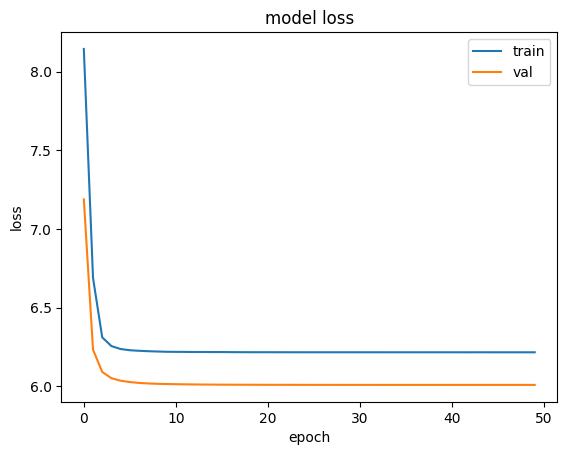

In [158]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

## Model 2

In [134]:
# Encode user_ids and place_ids
ratings_df["User_Id"] = ratings_df["User_Id"].astype("category").cat.codes
ratings_df["Place_Id"] = ratings_df["Place_Id"].astype("category").cat.codes

# Map the categorical ids back to original ids
user_id_map = pd.Series(ratings_df["User_Id"].values, index=ratings_df["User_Id"])
place_id_map = pd.Series(ratings_df["Place_Id"].values, index=ratings_df["Place_Id"])

# Create a new dataframe with the encoded ids
ratings_df_encoded = ratings_df[["User_Id", "Place_Id", "Place_Ratings"]]
train_df, test_df = train_test_split(ratings_df_encoded, test_size=0.2, random_state=42)

In [138]:
# Parameters
n_users = ratings_df_encoded["User_Id"].nunique()
n_items = ratings_df_encoded["Place_Id"].nunique()
embedding_dim = 20

# Model definition
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_dim, embeddings_regularizer=l2(1e-6), name='user_embedding')(user_input)
user_vec = Flatten(name='user_vec')(user_embedding)

item_input = Input(shape=(1,), name='item_input')
item_embedding = Embedding(input_dim=n_items, output_dim=embedding_dim, embeddings_regularizer=l2(1e-6), name='item_embedding')(item_input)
item_vec = Flatten(name='item_vec')(item_embedding)

# Increase Dropout regularization
user_vec = Dropout(0.7)(user_vec)
item_vec = Dropout(0.7)(item_vec)

dot_product = Dot(axes=1)([user_vec, item_vec])
output = Dense(1)(dot_product)

model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 20)                6000      ['user_input[0][0]']          
                                                                                                  
 item_embedding (Embedding)  (None, 1, 20)                6020      ['item_input[0][0]']          
                                                                                           

In [139]:
history = model.fit(
    [train_df["User_Id"], train_df["Place_Id"]],
    train_df["Place_Ratings"],
    batch_size=256,
    epochs=100,
    validation_data=([test_df["User_Id"], test_df["Place_Id"]], test_df["Place_Ratings"])
)

Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 11.2738 - val_loss: 10.8755
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 11.0777 - val_loss: 10.6830
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 10.8811 - val_loss: 10.4902
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 10.6834 - val_loss: 10.2927
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 10.4741 - val_loss: 10.0820
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 10.2494 - val_loss: 9.8506
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 9.9947 - val_loss: 9.5832
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 9.7051 - val_loss: 9.2753
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 9.3667 - val_loss: 8.9166
Epoch 10/100
32/32 [==============================] - 0s 4ms/step - loss: 8.9774 - val_loss: 8.50

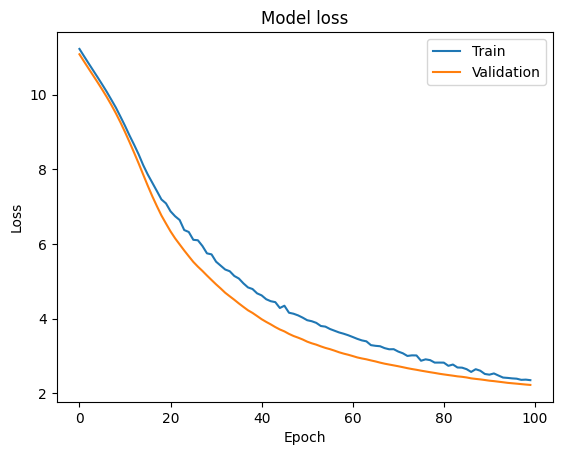

In [81]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [148]:
places_mapping = pd.Series(df["Place_Name"].values, index=df["Place_Id"]).to_dict()

# Function to get recommendations for a specific user
def recommendations(model, user_id, user_id_map, place_id_map):
    user_index = user_id_map.index[user_id_map == (user_id-1)][0]
    item_indices = np.setdiff1d(np.arange(n_items), train_df[train_df["User_Id"] == user_index]["Place_Id"])

    user_tensor = np.array([user_index] * len(item_indices))
    item_tensor = np.array(item_indices)

    preds = model.predict([user_tensor, item_tensor])

    top_indices = preds.flatten().argsort()[-5:][::-1]
    recommended_items = place_id_map.iloc[item_indices[top_indices]].values

    return recommended_items

# Example usage: Get recommendations for user with ID x
x = 3
print(f"Recommendations for user {x}:", recommendations(model, x, user_id_map, place_id_map))

9/9 [==============================] - 0s 2ms/step
Recommendations for user 3: [ 94  95  44  42 124]


[383 341  87 146  81]